<a href="https://colab.research.google.com/github/nigoda/machine_learning/blob/main/30(a)_Time_Series_Forecasting_with_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time series forecasting**

https://www.tensorflow.org/tutorials/structured_data/time_series

This is an introduction to time series forecasting using Recurrent Neural Network (RNNs). 

This is covered in two parts:
1.  Forecast a univariate time series.
2.  Forecast a mutlivariate time series.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in colab
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## **The weather dataset**

weather time series datsetset recorded by the Max-Plank-Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will only use the data collected between 2009 and 2016. This section of the dataset was prepared by Francois Chollet.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname = 'jena_climate_2009_2016.csv.zip',
    extract = True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 minutes. This means that, for a single hour, you will have 6 observations. Similarly, a single day 144 (6x24) observations.

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of of observations. Thus, you would create a window containing the last 720 (5x144) observations to train the model. Many such configurations are possible, making this dataset a god one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn. The `target_size` is the label that needs to be predicted.

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In both the following, the first 300,000 rows of data will be the training dataset, ans there remaining will be the validation dataset. This amount to ~2100 days worth of training data

In [ ]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [ ]:
tf.random.set_seed(13)

## **Part 1: Forecast a univariate time series**

First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0a0e22510>],
      dtype=object)

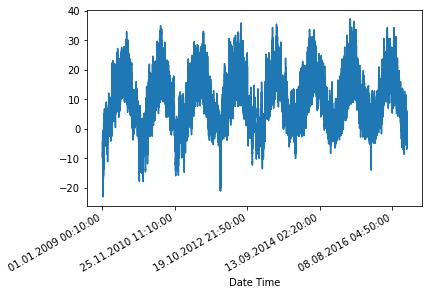

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividind by the standard deviation of each feature.

Note: The mean and standard deviation should only be computed using the training data.

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [ ]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recoded temperature observation,  and needs to learn to predict the temperature at the net time step.

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                           univariate_past_history,
                                           univariate_future_target)

This is what the `univariate_data` function returns.

In [ ]:
print('Single window of past history')
print(x_train_uni[0])

print('\n target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 target temperature to predict
-2.1041848598100876


Now that the data has been created, lets take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [ ]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

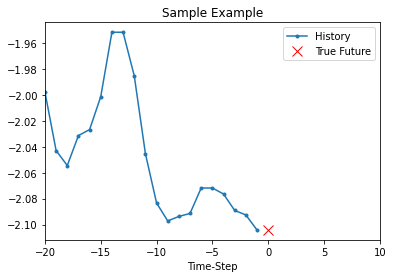

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### **Baseline**
Before procedding to train a model, Lets first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observation.

In [ ]:
def baseline(history):
  return np.mean(history)
  

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

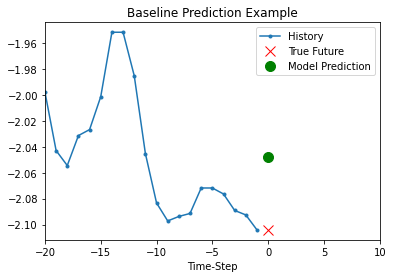

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

Let's see you can beat this baseline using a recuurrent neural network.

### **Recurrent neural network**
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. You will use a specialized RNN layer called Long Short Tem Memory(LSTM)

Let's now use `tf.data` to shufffle, batch, and cache the dataset.

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


You will see the LSTM requires the input shape of the data it is being given. This shape can be inferred from dataset created.

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
      tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model.

In [ ]:
for x, y in val_univariate.take(1):
  print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to large size of the dataset, in  the interest of saving time, each will only run for 200 steps, instead of the complete training data as normally done.

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 12ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0227 - val_loss:

### **Predict using the simple LSTM model**
Now that you have trained your simple LSTM. let's try and make a few predictions.

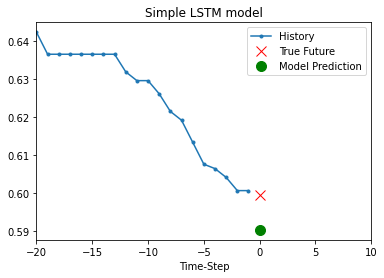

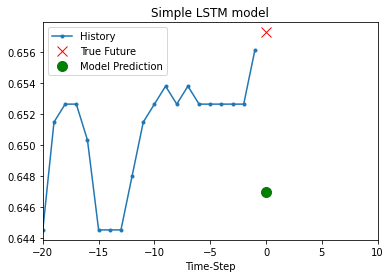

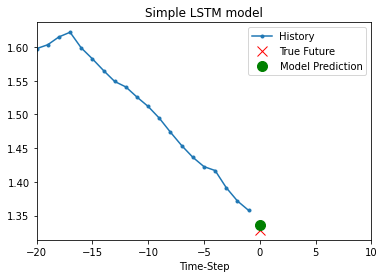

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline Now that you have seen that basics, let's move on to part two, Where you will with a multivariate time series.

### **Part 2: Forecast a multivariate time series**
The original dataset contains fourteen feature. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density.

To use more features, add their names to this list

In [ ]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [ ]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0a02cff50>,
      dtype=object)

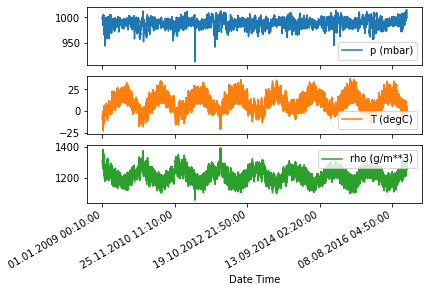

In [ ]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [ ]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

In [ ]:
dataset = (dataset-data_mean)/data_std

### **Single step model**
In a single step setup, the model learns to presdict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])

    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step= True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:,1], 
                                                   TRAIN_SPLIT,None, past_history,
                                                   future_target,STEP,
                                                   single_step= True)


Let's look at a single data-point

In [ ]:
print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [ ]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape) 

(256, 1)


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)


Epoch 1/10
200/200 [==============================] - 21s 95ms/step - loss: 0.3192 - val_loss: 0.2692
Epoch 2/10
200/200 [==============================] - 19s 95ms/step - loss: 0.2686 - val_loss: 0.2506
Epoch 3/10
200/200 [==============================] - 19s 94ms/step - loss: 0.2678 - val_loss: 0.2504
Epoch 4/10
200/200 [==============================] - 20s 100ms/step - loss: 0.2639 - val_loss: 0.2504
Epoch 5/10
200/200 [==============================] - 20s 98ms/step - loss: 0.2318 - val_loss: 0.2449
Epoch 6/10
200/200 [==============================] - 20s 98ms/step - loss: 0.2469 - val_loss: 0.2732
Epoch 7/10
200/200 [==============================] - 19s 96ms/step - loss: 0.2458 - val_loss: 0.2655
Epoch 8/10
200/200 [==============================] - 19s 96ms/step - loss: 0.2449 - val_loss: 0.2433
Epoch 9/10
200/200 [==============================] - 19s 96ms/step - loss: 0.2493 - val_loss: 0.2520
Epoch 10/10
200/200 [==============================] - 19s 97ms/step - loss: 0.24

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()


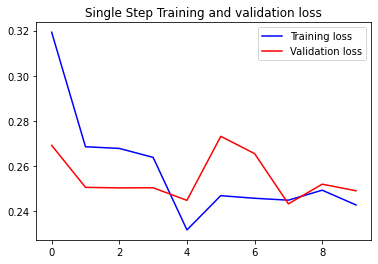

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

### **Predict a single step future**

Now that the model is trained. Let's make a few sample predictions. The model is given the history of three feature over the past five days sample every hour (120 data-points), since the goal is to predict the temperature, the plot only display the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction).

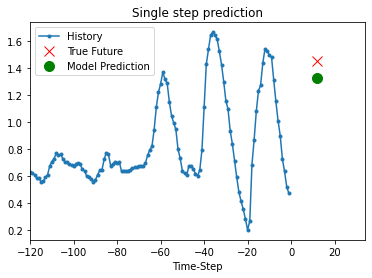

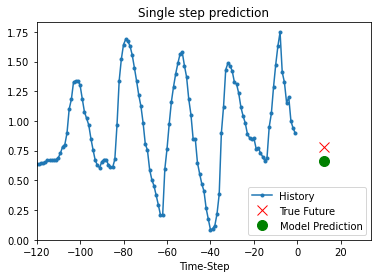

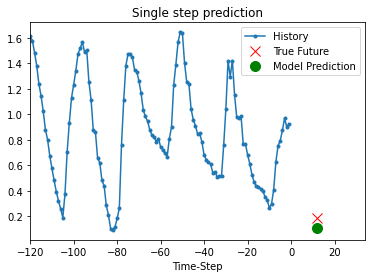

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                   single_step_model.predict(x)[0]], 12,
                   'Single step prediction')
  plot.show()

### **Multi-step model**
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model the training data again consist of recordings over the past five days sample every hour. However, here the model needs to learn to predict the temperature for the next 12 hours. since an observation is taken every 10 mintues, The output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP) 

Let's check out a sample data-point.

In [ ]:
print('Single window of past history: {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict: {}'.format(y_train_multi[0].shape))

Single window of past history: (120, 3)

 Target temperature to predict: (72,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_dvalata_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
t_data_multi = train_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

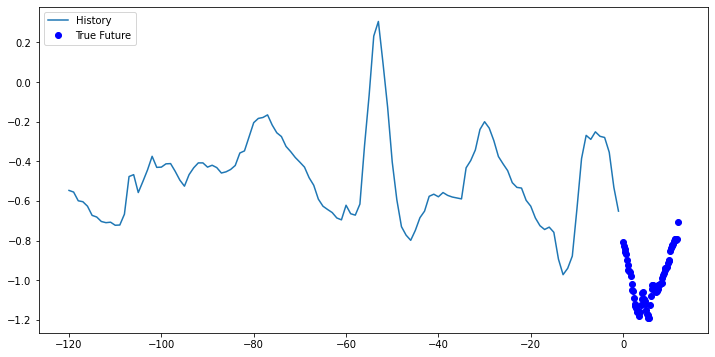

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers, since 72 predictions are made, the dense layer output 72 predictions.

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it train.

In [ ]:
for x, y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)

(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 38s 174ms/step - loss: 547.0751 - val_loss: 0.3827
Epoch 2/10
200/200 [==============================] - 34s 169ms/step - loss: 0.5114 - val_loss: 0.3033
Epoch 3/10
200/200 [==============================] - 34s 170ms/step - loss: 0.4931 - val_loss: 0.2843
Epoch 4/10
200/200 [==============================] - 34s 168ms/step - loss: 0.3233 - val_loss: 0.2392
Epoch 5/10
200/200 [==============================] - 34s 169ms/step - loss: 0.2328 - val_loss: 0.2237
Epoch 6/10
200/200 [==============================] - 38s 190ms/step - loss: 0.2254 - val_loss: 0.2301
Epoch 7/10
200/200 [==============================] - 40s 200ms/step - loss: 0.2160 - val_loss: 0.2158
Epoch 8/10
200/200 [==============================] - 40s 199ms/step - loss: 0.2104 - val_loss: 0.1989
Epoch 9/10
200/200 [==============================] - 40s 200ms/step - loss: 0.2124 - val_loss: 0.1965
Epoch 10/10
200/200 [==============================] - 40s 199ms/step -

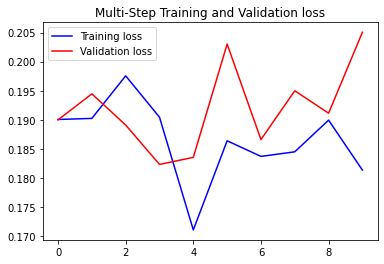

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and Validation loss')

### **Predict a multi-step future**
Let's now have a look at how well your network has learnt to predict the future.

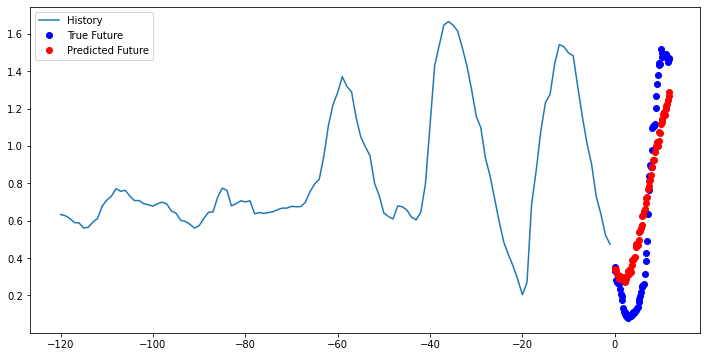

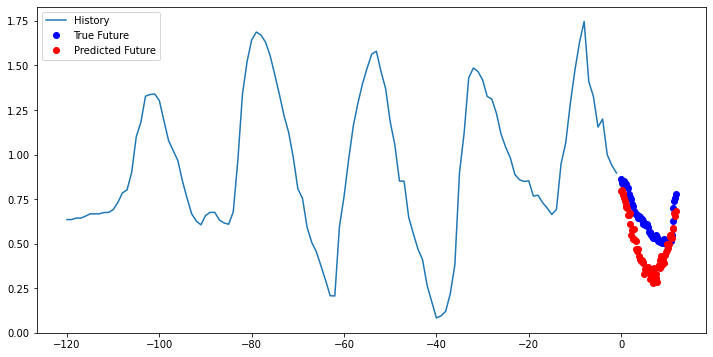

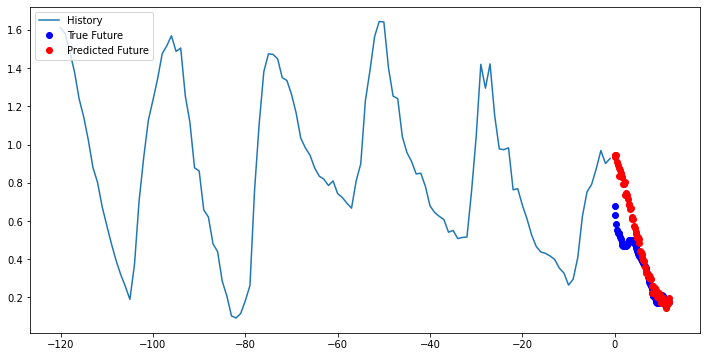

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])